# <span style="color:Red">Hierarchical Risk Parity</span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch

In [2]:
plt.style.use('dark_background')

In [3]:
retornos = pd.read_csv('data/returns_selected.csv',index_col=0)

retornos.index.names = ['Date']
retornos.index = pd.to_datetime(retornos.index)

In [4]:
retornos.head()

,LU0272423913,LU0474536744,LU0147408487,LU1160359102,LU1160358633,IE0004866889,LU0966156712,LU1048657123,LU0966156399,IE00B03HCY54,...,IE00BLY1N519,IE00BLY27S52,LU0963986467,LU0858297186,IE00BLWF5D72,IE00BLWF5F96,IE00BHCR9339,IE00BCRY5R01,LU0858297772,LU0963987275
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-06,-0.014990,-0.002037,-0.015796,-0.024757,-0.024781,-0.004787,-0.012550,-0.012539,-0.012622,0.0,...,-0.001022,-0.000932,0.000582,0.000619,-0.001010,-0.001013,0.000707,0.000683,0.000507,0.000606
2016-01-07,-0.022914,-0.040227,-0.022918,-0.037041,-0.037004,-0.051189,-0.025975,-0.025978,-0.025975,0.0,...,-0.001023,-0.001222,0.001066,-0.001134,-0.002022,-0.001014,-0.001566,-0.001588,-0.001014,0.001110
2016-01-08,-0.011099,0.008457,-0.003766,-0.017866,-0.017866,0.006274,-0.014878,-0.014899,-0.014929,0.0,...,-0.001024,-0.000833,-0.001260,-0.001032,0.000000,0.000000,0.000868,0.000812,-0.001015,-0.001110
2016-01-11,-0.013483,-0.034265,-0.019048,0.000870,0.000879,-0.038846,-0.012839,-0.012888,-0.012988,0.0,...,0.001024,0.000118,0.000679,-0.000930,0.000000,0.000000,-0.001010,-0.001026,-0.001016,0.000606
2016-01-12,-0.001132,0.004348,0.005753,0.005698,0.005757,0.005135,0.003064,0.003002,0.002993,0.0,...,0.000000,-0.000168,-0.001261,-0.001241,0.000000,0.000000,-0.000453,-0.000485,-0.001221,-0.001111


In [5]:
retornos_ff = retornos.copy()

In [6]:
retornos = pd.read_csv('data/retornosYF.csv',index_col=0)

retornos.index.names = ['Date']

retornos.index = pd.to_datetime(retornos.index)

In [7]:
retornos.head()

,AAPL,DIS,MSFT,AMZN,GOOG
Date,,,,,
2016-01-05,-0.025059,-0.020198,0.004562,-0.005024,0.000998
2016-01-06,-0.019570,-0.005352,-0.018165,-0.001799,0.001400
2016-01-07,-0.042205,-0.008569,-0.034783,-0.039058,-0.023170
2016-01-08,0.005288,-0.002512,0.003067,-0.001464,-0.016410
2016-01-11,0.016192,0.006751,-0.000574,0.017610,0.002183


In [8]:
retornos_ff = retornos.copy()

## <span style="color:white">Hierarchical Risk Parity Model</span>

In [9]:
# Función para calcular el Inverse Variance Portfolio
def InverseVariancePortfolio(cov):
    
    inverseVaR = 1./(np.diag(cov))

   
    inverseVaRTot = inverseVaR.sum()

   
    pesosIVP = inverseVaR/inverseVaRTot

   
    return pesosIVP


In [10]:
def VarianzaCluster(cov, pos):
    
   
    covCluster = cov.loc[pos, pos]

    
    pesos = InverseVariancePortfolio(covCluster).reshape(-1,1)

    varCluster = np.dot(np.dot(pesos.T,covCluster),pesos)[0,0]

    
    return varCluster

In [11]:
def CuasiDiagonalizacion(link):
    

    link = link.astype(int)

    serieOrd = pd.Series([link[-1,0],link[-1,1]])

    numActivos = link[-1,3]

    while serieOrd.max() >= numActivos:

        serieOrd.index = range(0,serieOrd.shape[0]*2,2)

        clusters = serieOrd[serieOrd >= numActivos]

        i = clusters.index

        j = clusters.values - numActivos

        serieOrd[i] = link[j,0]

        clusters = pd.Series(link[j,1],index=i+1)
        serieOrd = pd.concat([serieOrd,clusters])

        serieOrd = serieOrd.sort_index()
        serieOrd.index = range(serieOrd.shape[0])
        
    
    return serieOrd.tolist()

In [12]:
def BiseccionRec(cov,listaOrd):
    

    pesosHRP = pd.Series(1, index=listaOrd)

    L = [listaOrd]

    while len(L) > 0: 
        L = [i[j:k] for i in L for j,k in ((0,len(i)//2),(len(i)//2,len(i))) if len(i)>1]

        for i in range(0,len(L),2): 
            L0 = L[i] 
            L1 = L[i+1] 

            Var0 = VarianzaCluster(cov,L0) 
            Var1 = VarianzaCluster(cov,L1)

            alpha = 1 - Var0/(Var0 + Var1)

            pesosHRP[L0] = alpha * pesosHRP[L0] 
            pesosHRP[L1] = (1-alpha) * pesosHRP[L1]
    return pesosHRP

In [13]:
cov = retornos_ff.cov()
corr = retornos_ff.corr() 

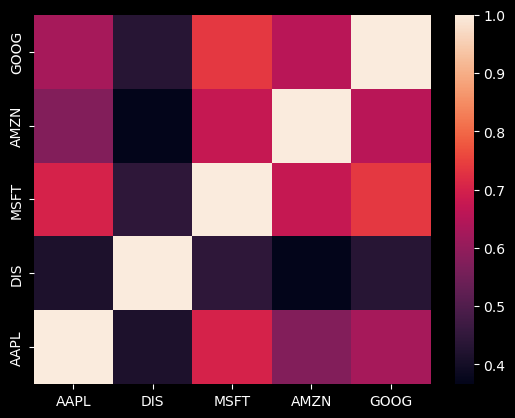

In [14]:
ax = sns.heatmap(corr)
ax.invert_yaxis()

In [15]:
dist = ((1-corr)/2.)**.5 
dist

,AAPL,DIS,MSFT,AMZN,GOOG
AAPL,0.000000,0.541264,0.386901,0.460512,0.432419
DIS,0.541264,0.000000,0.526797,0.563131,0.533071
MSFT,0.386901,0.526797,0.000000,0.403193,0.363185
AMZN,0.460512,0.563131,0.403193,0.000000,0.416068
GOOG,0.432419,0.533071,0.363185,0.416068,0.000000


In [16]:
link = sch.linkage(dist, 'single')
link

/var/folders/lr/vt7z07r96xs_kf3mfyld482m0000gn/T/ipykernel_20075/1326467571.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(dist, 'single')


array([[2.        , 4.        , 0.5158335 , 2.        ],
       [0.        , 5.        , 0.55468214, 3.        ],
       [3.        , 6.        , 0.57850246, 4.        ],
       [1.        , 7.        , 0.79130589, 5.        ]])

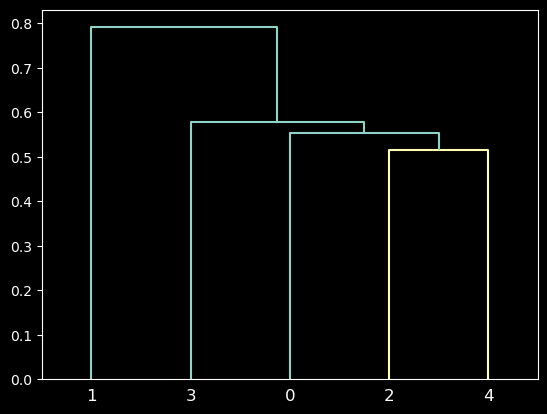

In [17]:
sch.dendrogram(link)
plt.show()

In [18]:
serieOrd = CuasiDiagonalizacion(link)


ind = corr.index[serieOrd].tolist()
ind

['DIS', 'AMZN', 'AAPL', 'MSFT', 'GOOG']

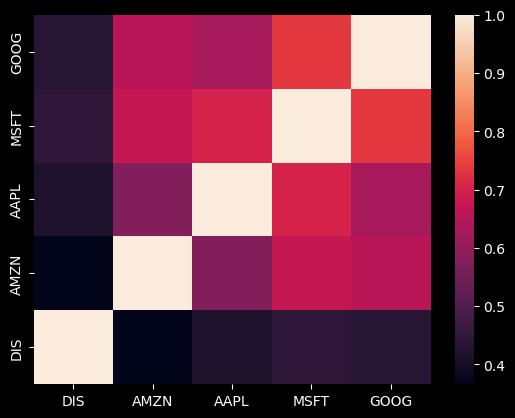

In [19]:
ax = sns.heatmap(corr.loc[ind,ind])
ax.invert_yaxis()

In [20]:
pesosHRP = BiseccionRec(cov, ind)
pesosHRP

/var/folders/lr/vt7z07r96xs_kf3mfyld482m0000gn/T/ipykernel_20075/3076853767.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.49856289 0.49856289]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pesosHRP[L0] = alpha * pesosHRP[L0]


DIS     0.283939
AMZN    0.214624
AAPL    0.224351
MSFT    0.145339
GOOG    0.131747
dtype: float64

In [21]:

pesosHRP.sum()

1.0

In [22]:

pd.DataFrame(pesosHRP.T, index=retornos_ff.columns, columns=['pesos'])

,pesos
AAPL,0.224351
DIS,0.283939
MSFT,0.145339
AMZN,0.214624
GOOG,0.131747


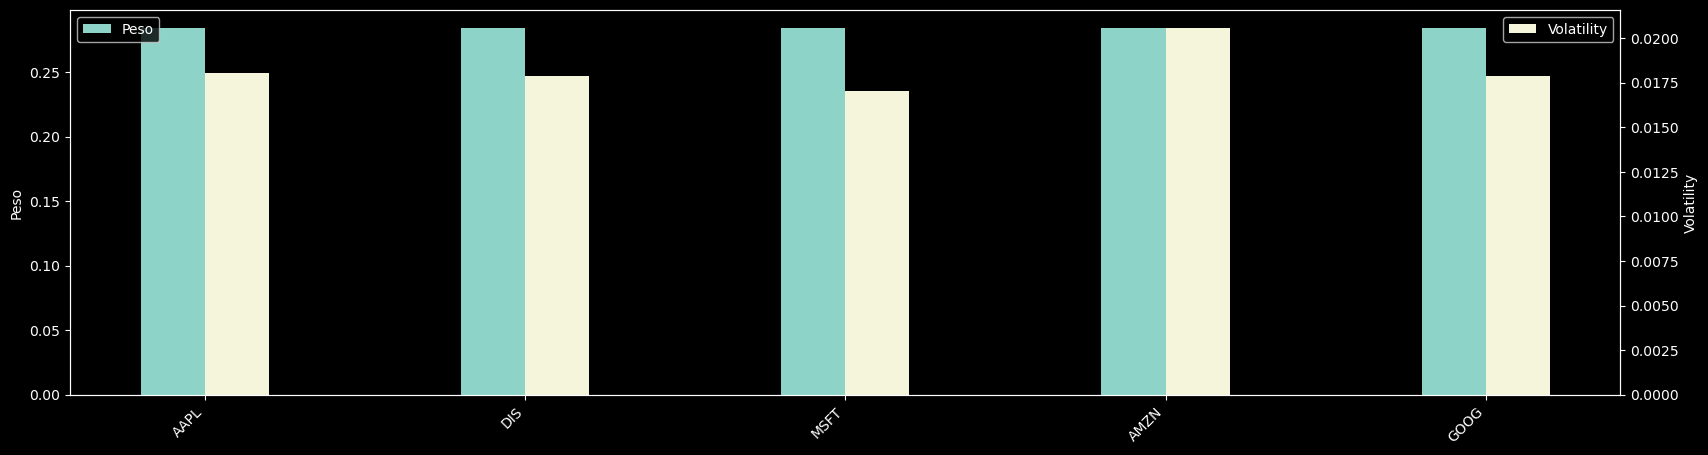

In [24]:
fig, ax1 = plt.subplots(figsize=(20,5))


ax1.bar(x=np.arange(retornos_ff.shape[1])-0.1, height=np.array(pesosHRP)[0], width=0.2, label='Peso')
ax1.set_xticks(np.arange(retornos_ff.shape[1]))
ax1.set_xticklabels(retornos_ff.columns, rotation=45, ha='right')
ax1.set_ylabel('Peso')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.bar(x=np.arange(retornos_ff.shape[1])+0.1, height=retornos_ff.std(), width=0.2, label='Volatility', color='beige')
ax2.set_ylabel('Volatility')
ax2.legend(loc='upper right')

plt.show()

In [25]:
sigma = np.sqrt(np.dot(np.dot(pesosHRP,cov),pesosHRP.T))
sigma

0.014613690252001918

In [26]:
RC = np.multiply(np.dot(cov,pesosHRP.T),pesosHRP.T)/sigma
RC

DIS     0.004413
AMZN    0.002563
AAPL    0.003363
MSFT    0.002342
GOOG    0.001932
dtype: float64

In [27]:
RC.sum()

0.014613690252001918